In [1]:
# Basic python modules
import numpy as np
import matplotlib.pyplot as plt
import os

# OQ modules
from openquake.hazardlib.gsim import get_available_gsims
#from openquake.hazardlib.gsim.base import RuptureContext, SitesContext, DistancesContext # Desactualizado
from openquake.hazardlib.contexts import RuptureContext, SitesContext, DistancesContext
from openquake.hazardlib.imt import SA
from openquake.hazardlib import const

from openquake.hazardlib.valid import gsim

In [2]:
gmpe_list = get_available_gsims()

for gmpe in gmpe_list:
    print(gmpe)

AbrahamsonEtAl2014
AbrahamsonEtAl2014NSHMPLower
AbrahamsonEtAl2014NSHMPMean
AbrahamsonEtAl2014NSHMPUpper
AbrahamsonEtAl2014RegCHN
AbrahamsonEtAl2014RegJPN
AbrahamsonEtAl2014RegTWN
AbrahamsonEtAl2015SInter
AbrahamsonEtAl2015SInterHigh
AbrahamsonEtAl2015SInterLow
AbrahamsonEtAl2015SInter_scaled
AbrahamsonEtAl2015SSlab
AbrahamsonEtAl2015SSlabHigh
AbrahamsonEtAl2015SSlabLow
AbrahamsonEtAl2015SSlab_scaled
AbrahamsonEtAl2018SInter
AbrahamsonEtAl2018SInterHigh
AbrahamsonEtAl2018SInterLow
AbrahamsonEtAl2018SSlab
AbrahamsonEtAl2018SSlabHigh
AbrahamsonEtAl2018SSlabLow
AbrahamsonGulerce2020SInter
AbrahamsonGulerce2020SInterAlaska
AbrahamsonGulerce2020SInterCascadia
AbrahamsonGulerce2020SInterCentralAmericaMexico
AbrahamsonGulerce2020SInterJapan
AbrahamsonGulerce2020SInterNewZealand
AbrahamsonGulerce2020SInterSouthAmerica
AbrahamsonGulerce2020SInterTaiwan
AbrahamsonGulerce2020SSlab
AbrahamsonGulerce2020SSlabAlaska
AbrahamsonGulerce2020SSlabCascadia
AbrahamsonGulerce2020SSlabCentralAmericaMexico
Ab

In [3]:
print("Nro de ecuaciones:",len(gmpe_list))

Nro de ecuaciones: 894


In [4]:
gmpes=[
    gsim("[MontalvaEtAl2017SInter]"),
    gsim("[AbrahamsonGulerce2020SInter]"),
    gsim("[ParkerEtAl2020SInter]"),
    gsim("[KuehnEtAl2020SInter]")
]

In [5]:
for gmpe in gmpes:
    print(str(gmpe))
    print("Rupture:",list(gmpe.REQUIRES_RUPTURE_PARAMETERS))
    print("Sites:",list(gmpe.REQUIRES_SITES_PARAMETERS))
    print("Distance:",list(gmpe.REQUIRES_DISTANCES))
    print("\n")

[MontalvaEtAl2017SInter]
Rupture: ['mag']
Sites: ['vs30', 'backarc']
Distance: ['rrup']


[AbrahamsonGulerce2020SInter]
Rupture: ['mag']
Sites: ['vs30']
Distance: ['rrup']


[ParkerEtAl2020SInter]
Rupture: ['mag']
Sites: ['vs30']
Distance: ['rrup']


[KuehnEtAl2020SInter]
Rupture: ['mag', 'ztor']
Sites: ['vs30']
Distance: ['rrup']




In [6]:
# Rupture Context

rctx = RuptureContext()
rctx.mag = np.array([9.0])
rctx.ztor = np.array([50.0])

# Sites Context

sctx = SitesContext()
sctx.vs30 = np.array([760.0])
sctx.backarc = np.array([0])
sctx.sids = np.array([1])

# Distance Context

dctx = DistancesContext()
dctx.rrup = np.array([120.0])

In [7]:
# # periods = np.logspace(-2, 1, 100)
# periods=np.array([0.01,0.03,0.05,0.1,0.2,0.5,0.75,1.0,2.0])
# print(periods)

In [8]:
periods = np.logspace(-2, 1, 100) # 0.01 a 10, 100 numeros

imts = [SA(period) for period in periods] # list comprehension

stddev_types = [const.StdDev.TOTAL]

In [9]:
def calculate_ground_motions(gmpes, imts, sctx, rctx, dctx, stddev_types):
    """
    Calculates the expected ground motion and uncertainty, organised by GMPE
    and intensity measure type (i.e. PGA, SA etc.), for a given rupture-site configuration    
    """
    results = {}
    nper = len(imts)
    for gmpe in gmpes:
        print("Running GMPE %s" % str(gmpe))
        results[str(gmpe)] = {"mean": np.zeros(nper),
                              "stddevs": np.zeros(nper),
                              "mean_plus_1sd": np.zeros(nper),
                              "mean_minus_1sd": np.zeros(nper)}
        for i, imt in enumerate(imts):
            try:
                mean, [stddev] = gmpe.get_mean_and_stddevs(
                    sctx, rctx, dctx, imt, stddev_types)
                results[str(gmpe)]["mean"][i] = np.exp(mean) # e^ln(Sa)
                results[str(gmpe)]["stddevs"][i] = stddev # sd
                results[str(gmpe)]["mean_plus_1sd"][i] = np.exp(mean + stddev) # e^(ln(Sa) + sd) - P84
                results[str(gmpe)]["mean_minus_1sd"][i] = np.exp(mean - stddev) # e^(ln(Sa) - sd) - P16
            except KeyError:
                results[str(gmpe)]["mean"][i] = np.nan
                results[str(gmpe)]["stddevs"][i] = np.nan
                results[str(gmpe)]["mean_plus_1sd"][i] = np.nan
                results[str(gmpe)]["mean_minus_1sd"][i] = np.nan
    return results


In [10]:
results = calculate_ground_motions(gmpes, imts, sctx, rctx, dctx, stddev_types)

Running GMPE [MontalvaEtAl2017SInter]
Running GMPE [AbrahamsonGulerce2020SInter]
Running GMPE [ParkerEtAl2020SInter]
Running GMPE [KuehnEtAl2020SInter]


/var/folders/xt/h6m5q8xs5qs7f905tg1pwtz80000gn/T/ipykernel_85672/3058179106.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[str(gmpe)]["mean"][i] = np.exp(mean) # e^ln(Sa)
/var/folders/xt/h6m5q8xs5qs7f905tg1pwtz80000gn/T/ipykernel_85672/3058179106.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[str(gmpe)]["stddevs"][i] = stddev # sd
/var/folders/xt/h6m5q8xs5qs7f905tg1pwtz80000gn/T/ipykernel_85672/3058179106.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Depre

In [11]:
for key in results.keys():
    print(str(key))
    print(results[key])

[MontalvaEtAl2017SInter]
{'mean': array([0.1173414 , 0.11770245, 0.11806462, 0.11842789, 0.11879229,
       0.1191578 , 0.11952444, 0.11989221, 0.12026111, 0.12063114,
       0.12116967, 0.12409167, 0.12704152, 0.13001891, 0.13302355,
       0.13605511, 0.13911326, 0.14219767, 0.14530799, 0.14844386,
       0.15160494, 0.15479084, 0.15800119, 0.1612356 , 0.16739489,
       0.17399089, 0.180834  , 0.18793304, 0.1952971 , 0.20297859,
       0.21127599, 0.21991458, 0.22890809, 0.23827074, 0.24834358,
       0.25866612, 0.26922317, 0.27999612, 0.29096263, 0.30176796,
       0.31087298, 0.31928927, 0.32687815, 0.33215315, 0.32840508,
       0.3238644 , 0.31850578, 0.30149254, 0.28248019, 0.26573545,
       0.25580817, 0.2453255 , 0.23433854, 0.22266343, 0.20953276,
       0.19692829, 0.18484154, 0.17240341, 0.16049675, 0.1499783 ,
       0.14163363, 0.13369936, 0.12621672, 0.1195358 , 0.11323711,
       0.1072977 , 0.10169607, 0.09253521, 0.08412928, 0.0764231 ,
       0.06936485, 0.0629059

In [12]:
import pandas as pd

df_spectrums = pd.Series(periods, name="periods")

for gmpe in gmpes:
    actual_spectrum = pd.Series(results[str(gmpe)]["mean_plus_1sd"], name=str(gmpe))
    df_spectrums = pd.concat([df_spectrums, actual_spectrum], axis=1)


df_spectrums

df_spectrums.to_excel("espectros_interfase.xlsx")

# NaN: Not a Number 

In [13]:
df_spectrums

,periods,[MontalvaEtAl2017SInter],[AbrahamsonGulerce2020SInter],[ParkerEtAl2020SInter],[KuehnEtAl2020SInter]
0,0.010000,0.271385,0.241222,0.253149,0.513199
1,0.010723,0.272431,0.242994,0.253794,0.518770
2,0.011498,0.273482,0.244778,0.254440,0.524399
3,0.012328,0.274537,0.246575,0.255088,0.530086
4,0.013219,0.275596,0.248385,0.255737,0.535832
...,...,...,...,...,...
95,7.564633,0.024493,0.028834,0.014579,0.027371
96,8.111308,0.024063,0.026816,0.012990,0.025083
97,8.697490,0.023639,0.024938,0.011574,0.022965
98,9.326033,0.023224,0.023192,0.010312,0.021005


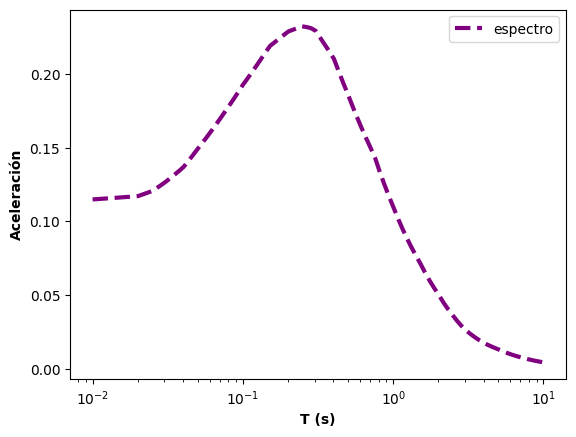

In [14]:
fig,ax=plt.subplots()

ax.set_xscale("log")

ax.plot(periods,results["[ParkerEtAl2020SInter]"]["mean"],lw=3,ls="dashed",color="purple",label="espectro")

# ax.grid(which="both")

ax.set_xlabel("T (s)",fontweight="bold")
ax.set_ylabel("Aceleración",fontweight="bold")

ax.legend()
fig.savefig("espectro.png")